# Applying Monte Carlo to determine Life Insurance Pricing

***Following this [demonstration](https://www.slideshare.net/AdamConrad2/actuarial-application-of-monte-carlo-simulation-46703744) of Monte Carlo analysis to price life insurance risk. (A.Conrad)***

## Problem statement:
A man and wife couple are looking to purchase a life insurance policy for:
- Policy term of 20 years or until death.
- payout $300,000
- monthly premiums

If a number ($n$) of policies are to be sold on the Life Insurance book each year, what is the monthly premium required per policy to ensure that the total premium collected exceeds the expected value of claims paid?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Males
- coverage avaliable to males aged 30 - 70
- typically age of male at purchase is 50.
- younger insureds generally purchase 40-year terms. 
- older insured purchase 20-year terms.
- male insured age follow a normal distributions

$mA = N(\mu=45,\sigma=5)$



Sample mean: 45.02
Sample StdDev: 7.48


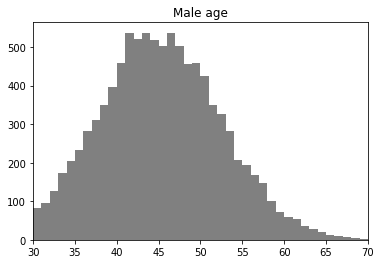

In [2]:
maleMu = 45
maleSigma = 7.5
maleAges = list()

for i in range(10000):
    maleAges.append(np.random.normal(maleMu,maleSigma))

plt.title('Male age');
plt.hist(maleAges, bins=np.arange(0,71,1), color='grey');
plt.xlim(30,70);
print('Sample mean: {:.2f}\nSample StdDev: {:.2f}'.format(np.mean(maleAges),np.std(maleAges)))

# Age of wife
the ages of wives are given relative to the age of the husband. 
- 32.4 % are the same age as husbands. 
- 55.4 % are younger than husbands. 
- 12.3 % are older than husbands. 
- on average wifes are 2.3 years younger than husbands $\sigma = 5.5$. 
- for older husbands, 1-17 years makes up 99.7 % ($3\sigma$)
- for older wives, 1-7 years makes up 99.7 % ($3\sigma$)

In [3]:
wifeRelative = pd.DataFrame(index=['m70','m20-69','m15-19','m10-14','m6-9','m4-5','m2-3','mw1',
                    'w2-3','w4-5','w6-9','w10-14','w15-19','w20-69','w70'],
             columns=['pOlder'],
             data=[0,0.8,1.5,4.9,12.3,13.8,22.1,32.4,5.9,2.9,2.2,0.9,0.2,0.2,0])

In [4]:
# calculate wifes age relative to hubands
femaleAges = list()
ageDif = list()
wifeYounger = list()
sameAge = list()

for n,e in enumerate(maleAges):
    sameAge.append(np.random.binomial(1,0.324)) # is wife is same age?
    if sameAge[n] == 1: # if same age
        ageDif.append(0)
        wifeYounger.append(0)
        
    else: # if not same age
        wifeYounger.append(np.random.binomial(1,0.554)) # is wife younger?
        if wifeYounger[n] == 1:
            ageDif.append(-1*abs(np.random.normal(0,5.5))) # younger age dif
        else: # if older
            ageDif.append(abs(np.random.normal(0,2.5))) # olfer age dif
    
    femaleAges.append(maleAges[n]+ageDif[n])

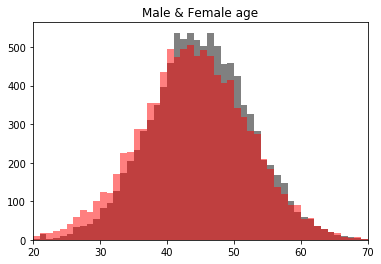

In [5]:
plt.title('Male & Female age');
plt.hist(maleAges, bins=np.arange(0,71,1), alpha=1, color='grey');
plt.hist(femaleAges, bins=np.arange(0,71,1), alpha=0.5, color='red');
plt.xlim(20,70);

# Male Mortality
- mean age of death is 76 
- ages 65 - 100 account for 99.7 % of deaths
- the distribution of males deaths is normal to the mean 76, and then exponentional

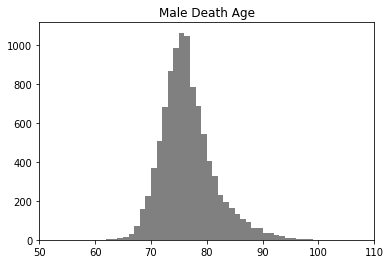

In [6]:
mort = 76
maleAboveMean = list()
maleAOD = list()

for i in range(10000):
    maleAboveMean.append(np.random.binomial(1,0.5))
    if maleAboveMean[i] == 1: # if male is > 76 y.o
        maleAOD.append(mort + np.random.exponential(4.167))
    else: # if male below 76 y.o
        maleAOD.append(mort - abs(np.random.normal(0,3.667)))
    
plt.hist(maleAOD, bins=np.arange(0,100,1),alpha=1, color='grey');
plt.title('Male Death Age');
plt.xlim(50,110);

# Femal Mortality
- mean age of death is 81 
- ages 65 - 100 account for 99.7 % of deaths
- the distribution of males deaths is normal to the mean 81, and then exponentional.

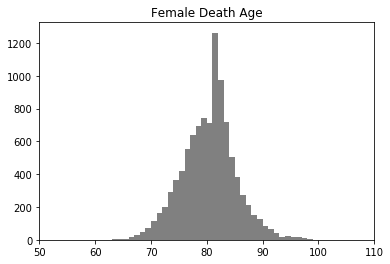

In [7]:
mort = 81
maleAboveMean = list()
femaleAOD = list()

for i in range(10000):
    maleAboveMean.append(np.random.binomial(1,0.5))
    if maleAboveMean[i] == 1: # if male is > 76 y.o
        femaleAOD.append(mort + np.random.exponential(3.271))
    else: # if male below 76 y.o
        femaleAOD.append(mort - abs(np.random.normal(0,5.333)))
    
plt.hist(femaleAOD, bins=np.arange(0,100,1),alpha=1, color='grey');
plt.title('Female Death Age');
plt.xlim(50,110);

# Expected policy lifespans (years of cover or to death)

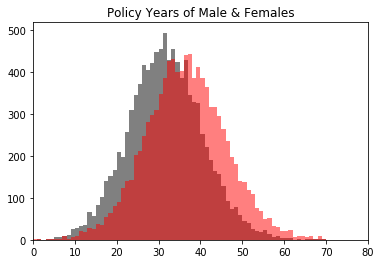

In [8]:
mPolicyYears = list()
fPolicyYears = list()
for n in range(10000):
    mPolicyYears.append(maleAOD[n] - maleAges[n])
    fPolicyYears.append(femaleAOD[n] - femaleAges[n])

plt.title('Policy Years of Male & Females');
plt.hist(mPolicyYears, bins=np.arange(0,71,1), alpha=1, color='grey');
plt.hist(fPolicyYears, bins=np.arange(0,71,1), alpha=0.5, color='red');
plt.xlim(0,80);

# Scenarios of Premiums vs. Claims 

| Scenario| Claim | Profit |
| --- | --- | --- |
| Husband survives | \$ 300,000 | Premium *Months Female Lived - \$250,000 |
| Wife survives | \$ 300,000 | Premium * Months Male Lived - \$250,000 |
| Both survive | \$ 0 | Premium * Months|

if m < 20 or f < 20 # someone has died
    if m < f # male died first
        cost = claim + life of male
    if f < m # female died first
        cost = claim + life of female
else: # both survive
    cost = life of term.

In [15]:
def simPrice(nYears,coverage,premium,verbose=False):
    POC = list() # premiums over claims (profit/loss)
    
    for year in range(nYears): # simulates years
        numClaims = 0 # total number of claims
        numPrems = list()  # total number of prems per policy
        claimsPaid = list() # claims values
        premsPaid = list() # prem values

        for e in range(1000): # sample policies
            i = np.random.randint(low=0,high=9999)
            if (mPolicyYears[i] < 20) or (fPolicyYears[i] < 20): # someone has died
                if mPolicyYears[i] > fPolicyYears[i]: # male survived
                    numClaims += 1 # claims made (for wifes death)
                    numPrems.append(12*fPolicyYears[i]) # months for years alive
                    claimsPaid.append(coverage)
                    premsPaid.append(premium*fPolicyYears[i])

                if mPolicyYears[i] < fPolicyYears[i]: # male died
                    numClaims += 1 # claims made (for wifes death)
                    numPrems.append(12*mPolicyYears[i]) # months for years alive
                    claimsPaid.append(coverage)
                    premsPaid.append(premium*mPolicyYears[i])

            # Both live (yay!)     
            else: 
                premsPaid.append(premium*12*20) # premiums collected
                claimsPaid.append(0) # no claim made

        POC.append(sum(premsPaid) - sum(claimsPaid))

    if verbose == True:
        print('Premium ${} for {} '
              'years simulation:'
              '\nMean profit {:.1f}'
              '\nStd-d proft {:.1f}'
              '\nWorst case profit ${:.1f}'.format(premium,
                                                   nYears,
                                                   np.mean(POC),
                                                   np.std(POC),
                                                   np.mean(POC) - (3* np.std(POC))
                                                  )
             )
    
    return np.mean(POC),np.std(POC),(np.mean(POC) - (3* np.std(POC))), (sum(claimsPaid)/ sum(premsPaid))

In [18]:
premiumRange = np.arange(70,210,10)
numberYears = 100

meanProfit = list()
stdProfit = list()
worstProfit = list()
lossRatio = list()

for prem in premiumRange:
    a,b,c,d,  = simPrice(numberYears, 300000, prem, verbose=False)
    meanProfit.append(a/1000000)
    stdProfit.append(b/1000000)
    worstProfit.append(c/1000000)
    lossRatio.append(d*100)
    

In [19]:
pd.DataFrame({'Premium':premiumRange,
              'AvgProfit ($M)':meanProfit,
              'Avg LR (%)':lossRatio,
              'StdProfit ($M)':stdProfit,
              'WorstCaseProfit ($M)':worstProfit,
              })

,Premium,AvgProfit ($M),Avg LR (%),StdProfit ($M),WorstCaseProfit ($M)
0,70,-17.190641,221.183776,2.916970,-25.941553
1,80,-15.283219,189.610053,3.062345,-24.470253
2,90,-12.771439,170.304476,2.561562,-20.456124
3,100,-11.123931,164.181968,2.742570,-19.351643
4,110,-8.903551,110.323580,3.587197,-19.665142
5,120,-6.270136,88.861630,3.159877,-15.749769
6,130,-3.716275,106.066499,3.634041,-14.618396
7,140,-2.063497,116.155353,3.280773,-11.905815
8,150,-0.155532,104.253553,3.311837,-10.091043
9,160,2.203515,97.728514,3.349701,-7.845587


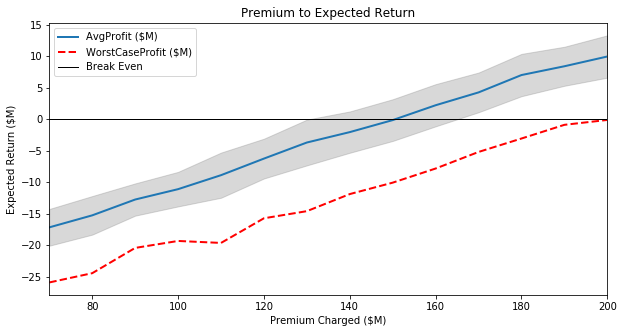

In [20]:
fig,axs = plt.subplots(1,1,figsize=(10,5))

axs.plot(premiumRange, meanProfit, label='AvgProfit ($M)',lw=2)
axs.fill_between(premiumRange,
                 y1=np.array(meanProfit)-np.array(stdProfit),
                 y2=np.array(meanProfit)+np.array(stdProfit),
                 color='grey',alpha=0.3)
axs.plot(premiumRange, worstProfit, label='WorstCaseProfit ($M)',c='red',linestyle='--',lw=2)
axs.plot([min(premiumRange),max(premiumRange)],[0,0], 'k-', label='Break Even',lw=1)

axs.set_xlim(min(premiumRange),max(premiumRange))
axs.set_ylabel('Expected Return ($M)')
axs.set_xlabel('Premium Charged ($M)')
axs.set_title('Premium to Expected Return')
axs.legend();